In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../utils/')
from data_utils import get_folders
from train_utils import train
from diagnostic_tools import count_params
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 128

In [5]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

In [6]:
# number of validation samples
val_size = len(val_folder.imgs)
val_size

10000

# Model

In [7]:
from get_densenet import get_model

In [8]:
model, criterion, optimizer = get_model()

In [9]:
# number of params in the model
count_params(model)

1106624

# Train

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs = 200
n_batches = ceil(train_size/batch_size)

lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=7, 
    verbose=True, threshold=0.01, threshold_mode='abs'
)

# total number of batches in the train set
n_batches

782

In [11]:
%%time
all_losses = train(
    model, criterion, optimizer,
    train_iterator, n_epochs, steps_per_epoch=n_batches,
    val_iterator=val_iterator, n_validation_batches=40,
    patience=14, threshold=0.01, # early stopping
    lr_scheduler=lr_scheduler
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  4.615 4.320  0.062 0.092  0.195 0.279  108.123
1  3.966 3.748  0.138 0.164  0.351 0.412  106.027
2  3.628 3.571  0.189 0.215  0.436 0.459  105.984
3  3.395 3.178  0.227 0.269  0.490 0.548  106.061
4  3.225 3.167  0.257 0.275  0.530 0.552  106.187
5  3.087 3.079  0.285 0.299  0.560 0.578  106.043
6  2.976 2.954  0.304 0.316  0.583 0.597  106.170
7  2.888 2.861  0.321 0.338  0.604 0.619  106.151
8  2.804 2.712  0.338 0.361  0.620 0.642  105.997
9  2.740 2.672  0.352 0.366  0.633 0.650  106.086
10  2.680 2.596  0.363 0.393  0.646 0.668  106.132
11  2.632 2.649  0.373 0.376  0.655 0.658  106.053
12  2.588 2.537  0.383 0.393  0.663 0.677  106.023
13  2.551 2.590  0.391 0.390  0.672 0.672  106.079
14  2.514 2.485  0.397 0.410  0.679 0.687  105.862
15  2.479 2.476  0.403 0.416  0.684 0.689  105.933
16  2.454 2.561  0.408 0.408  0.689 0.690  106.118
17  2.433 2.471  0.413 0.410  0.693 0.689  106.163
18  2.399 2.499  0.421 0.424  0.700 0.693  106.053
19  2.375 2.379  0.423 0.445  0.703 0.716

# Loss/epoch plots

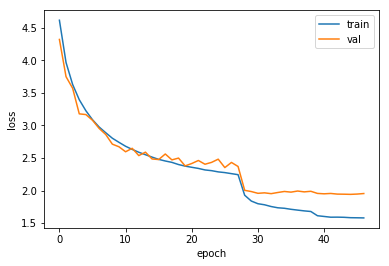

In [12]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

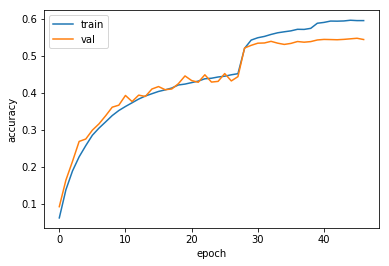

In [13]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

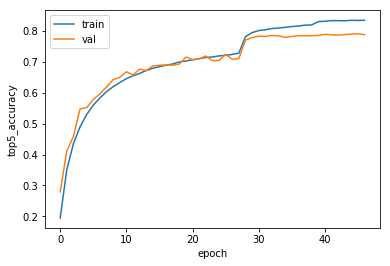

In [14]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [15]:
model.cpu();
torch.save(model.state_dict(), 'model.pytorch_state')